# Домашнее задание 4. Конструирование текстовых признаков из твитов пользователей

## Сбор данных

Первый этап - сбор твитов пользователей. Необходимо подключаться к Twitter API и запрашивать твиты по id пользователя. 
Подключение к API подробно описано в ДЗ 1.

In [61]:
import twitter
import json
import pickle
import re
import os
import wordcloud

In [62]:
with open("conf.json", 'r') as f:
    data = json.load(f)

CONSUMER_KEY = data["CONSUMER_KEY"]
CONSUMER_SECRET = data["CONSUMER_SECRET"]

ACCESS_TOKEN_KEY = data["ACCESS_TOKEN_KEY"]
ACCESS_TOKEN_SECRET = data["ACCESS_TOKEN_SECRET"]

api = twitter.Api(consumer_key=CONSUMER_KEY, 
                  consumer_secret=CONSUMER_SECRET, 
                  access_token_key=ACCESS_TOKEN_KEY, 
                  access_token_secret=ACCESS_TOKEN_SECRET,
                  sleep_on_rate_limit=True)

TMP_FILE_NAME = "tmp.pickle"

Для получения твитов пользователя может быть использован метод GetUserTimeline из библиотеки python-twitter. Он позволяет получить не более 200 твитов пользователя. По каждому пользователю достаточно собрать 200 твитов.

Метод имеет ограничение по количеству запросов в секунду. Для получения информации о промежутке времени, которое необходимо подождать для повторного обращения к API может быть использован метод `GetSleepTime`. Для получения информации об ограничениях запросов с помощью метода `GetUserTimeLine` необходимо вызывать `GetSleepTime` с параметром "statuses/user_timeline".

Метод GetUserTimeline возвращает объекты типа Status. У этих объектов есть метод AsDict, который позволяет представить твит в виде словаря.

Id пользователей необходимо считать из файла, как было сделано в ДЗ 1.

Необходимо реализовать функцию `get_user_tweets(user_id)`. Входной параметр - id пользователя из файла. Возвращаемое значение - массив твитов пользователя, где каждый твит представлен в виде словаря. Предполагается, что информация о пользователе содержится в твитах, которые пользователь написал сам. Это означает, что можно попробовать отфильтровать ответы другим пользователям, ссылки и ретвиты, а так же картинки и видео, так как наша цель - найти текстовую информацию.

In [63]:
not_fit_keys = ["in_reply_to_screen_name", "retweeted_status"]
def filter_status(status):
    for key in not_fit_keys:
        if key in status.keys():
            return False
    if "text" not in status.keys():
        return False
    elif re.match("https://", status["text"]):#it means no text, only media
        return False
    return True

In [64]:
def get_user_tweets(id_, user_twitts):
    """returns list of tweets as dicts"""
    # your code here
    user_twitts[id_] = []
    try:
        statuses = api.GetUserTimeline(user_id=id_)
    except twitter.TwitterError as e:
        return
    res = []
    for status in statuses:
        d = status.AsDict()
        if filter_status(d):
            res.append(d)
    user_twitts[id_] = res

## Разбор текста твита

Обработка текста предполагает разбиение текста на отдельные элементы - параграфы, предложения, слова. Мы будем преобразовывать текст твита к словам. Для этого текст необходимо разбить на слова. Сделать это можно, например, с помощью регулярного выражения.

Необходимо реализовать функцию, `get_words(text)`. Входной параметр - строка с текстом. Возвращаемое значение - массив строк (слов). Обратите внимание, что нужно учесть возможное наличие пунктуации и выделить по возможности только слова. 

In [65]:
def get_words(text):
    """returns list of words"""
    regexp = (r"""(?:[^\W\d_](?:[^\W\d_]|['\-_])+[^\W\d_])""",r"""(?:@[\w_]+)""",r"""[\w.+-]+@[\w-]+\.(?:[\w-]\.?)+[\w-]""",)
    word_re= re.compile(r"""(%s)""" % "|".join(regexp), re.I)
    words = word_re.findall(text)

    res = []
    for word in words:
        if word.find('@') != -1:
            continue
        res.append(word.lower())
    return res

Далее полученные слова необходимо привести к нормальной форме. То есть привести их к форме единственного числа настоящего времени и пр. Сделать это можно с помощью библиотеки nltk. Информацию по загрузке, установке библиотеки и примерах использования можно найти на сайте http://www.nltk.org/

Для загрузки всех необходимых словарей можно воспользоваться методом download из библиотеки nltk.

In [7]:
import nltk
# nltk.download()

Для дальнейшей обработки слова должны быть приведены к нижнему регистру. 

Для приведения к нормальной форме можно использовать `WordNetLemmatizer` из библиотеки nltk. У этого класса есть метод `lemmatize`.

Также необходимо убрать из текста так называемые стоп-слова. Это часто используемые слова, не несущие смысловой нагрузки для наших задач. Сделать это можно с помощью `stopwords` из nltk.corpus

Необходимо реализовать функцию `get_tokens(words)`. Входной параметр - массив слов. Возвращаемое значение - массив токенов.

In [66]:
from nltk import WordNetLemmatizer
from nltk.corpus import stopwords
english_words =  set(w.lower() for w in nltk.corpus.words.words())
stops = set(stopwords.words('english'))

def get_tokens(words):
    """returns list of tokens"""
    # your code here
    lematizer = WordNetLemmatizer()
    words = [w for w in words if w not in stops]
    tokens = [lematizer.lemmatize(t) for t in words]
    result = list(set(tokens).intersection(english_words))
    return result

In [67]:
print get_tokens(["here", "are", "differences", "words", "geese", "abyrwalg", "running", "http"])

[u'goose', 'running', u'difference', u'word']


Необходимо реализовать функцию `get_tweet_tokens(tweet)`. Входной параметр - текст твита. Возвращаемое значение -- токены твита. 

In [68]:
def get_tweet_tokens(tweet):
    # your code here
    words = get_words(tweet)
    return get_tokens(words)

Необходимо реализовать функцию `collect_users_tokens()`. Функция должна сконструировать матрицу признаков пользователей. В этой матрице строка - пользователь. Столбец - токен. На пересечении - сколько раз токен встречается у пользователя.
Для построения матрицы можно использовать `DictVectorizer` из `sklearn.feature_extraction`.

In [69]:
def update_dict(tokens, freq):
    for token in tokens:
        if token in freq:
            freq[token] += 1
        else:
            freq[token] = 1

In [72]:
def collect_users_tokens(df_users):
    """returns users list and list of user dicts. Each dict contains frequence of user tokens"""
    # your code here
    # save intermediate result
    
    user_twitts = {}
    if os.path.exists(TMP_FILE_NAME):
        with open(TMP_FILE_NAME, 'rb') as f:
            user_twitts = pickle.load(f)
    print "Data is loaded"

    for id_ in df_users["uid"]:
        if id_ not in user_twitts:
            get_user_tweets(id_,user_twitts)
    print "Data is collected"
    
    with open(TMP_FILE_NAME, 'wb') as f:
                pickle.dump(user_twitts, f)
    
    print "Data is saved"
    
    result_list = []
    users = []
    for user,statuses in user_twitts.iteritems():
        token_freq = {}
        for status in statuses:
            tokens = get_tweet_tokens(status["text"])
            update_dict(tokens, token_freq)
        if token_freq:
            result_list.append(token_freq)
            users.append(user)
    return users, result_list


In [73]:
import pandas as pd
from collections import defaultdict
import json
from sklearn.feature_extraction import DictVectorizer


TRAINING_SET_URL = "train.csv"
EXAMPLE_SET_URL = "test.csv"
df_users_train = pd.read_csv(TRAINING_SET_URL, sep=",", header=0, names=["uid", "cls"])
df_users_ex = pd.read_csv(EXAMPLE_SET_URL, sep=",", header=0, names=["uid"])
df_users_ex['cls'] = None
df_users = pd.concat([df_users_train, df_users_ex])


#collect_info(df_users)
users, users_tokens = collect_users_tokens(df_users)
print "Tokens are collected"
v = DictVectorizer()
vs = v.fit_transform(users_tokens)

Data is loaded
Data is collected
Data is saved
Tokens are collected


In [76]:
import numpy as np
np.savez("out_4.dat", data=vs, users=users, users_tokens=users_tokens )

Далее для получения представления о полученной информацию о токенах предлагается отобразить ее в виде облака тэгов. [Подсказка](http://anokhin.github.io/img/tag_cloud.png). 

In [80]:
def draw_tag_cloud(v, vs):
    """Draws tag cloud of found tokens"""
    # your code here
    filename = "cloud.png"
    frequencies = np.asarray(vs.sum(axis=0)) #total sum
    frequencies = frequencies.reshape(frequencies.shape[1]) #as one dim array
    
    total = np.sum(frequencies)# normalize
    normalized_frequencies = frequencies / total
    words = v.get_feature_names()
    
    to_cloud = []
    for i, word in enumerate(words):
        to_cloud.append((word, frequencies[i]))
    
    to_cloud.sort(key=lambda x: x[1], reverse=True)
    
    cloud = wordcloud.WordCloud(width=1920, height=1080, max_words=1000)
    cloud.fit_words(to_cloud)
    cloud.to_file(filename)
    return

In [81]:
draw_tag_cloud(v, vs)

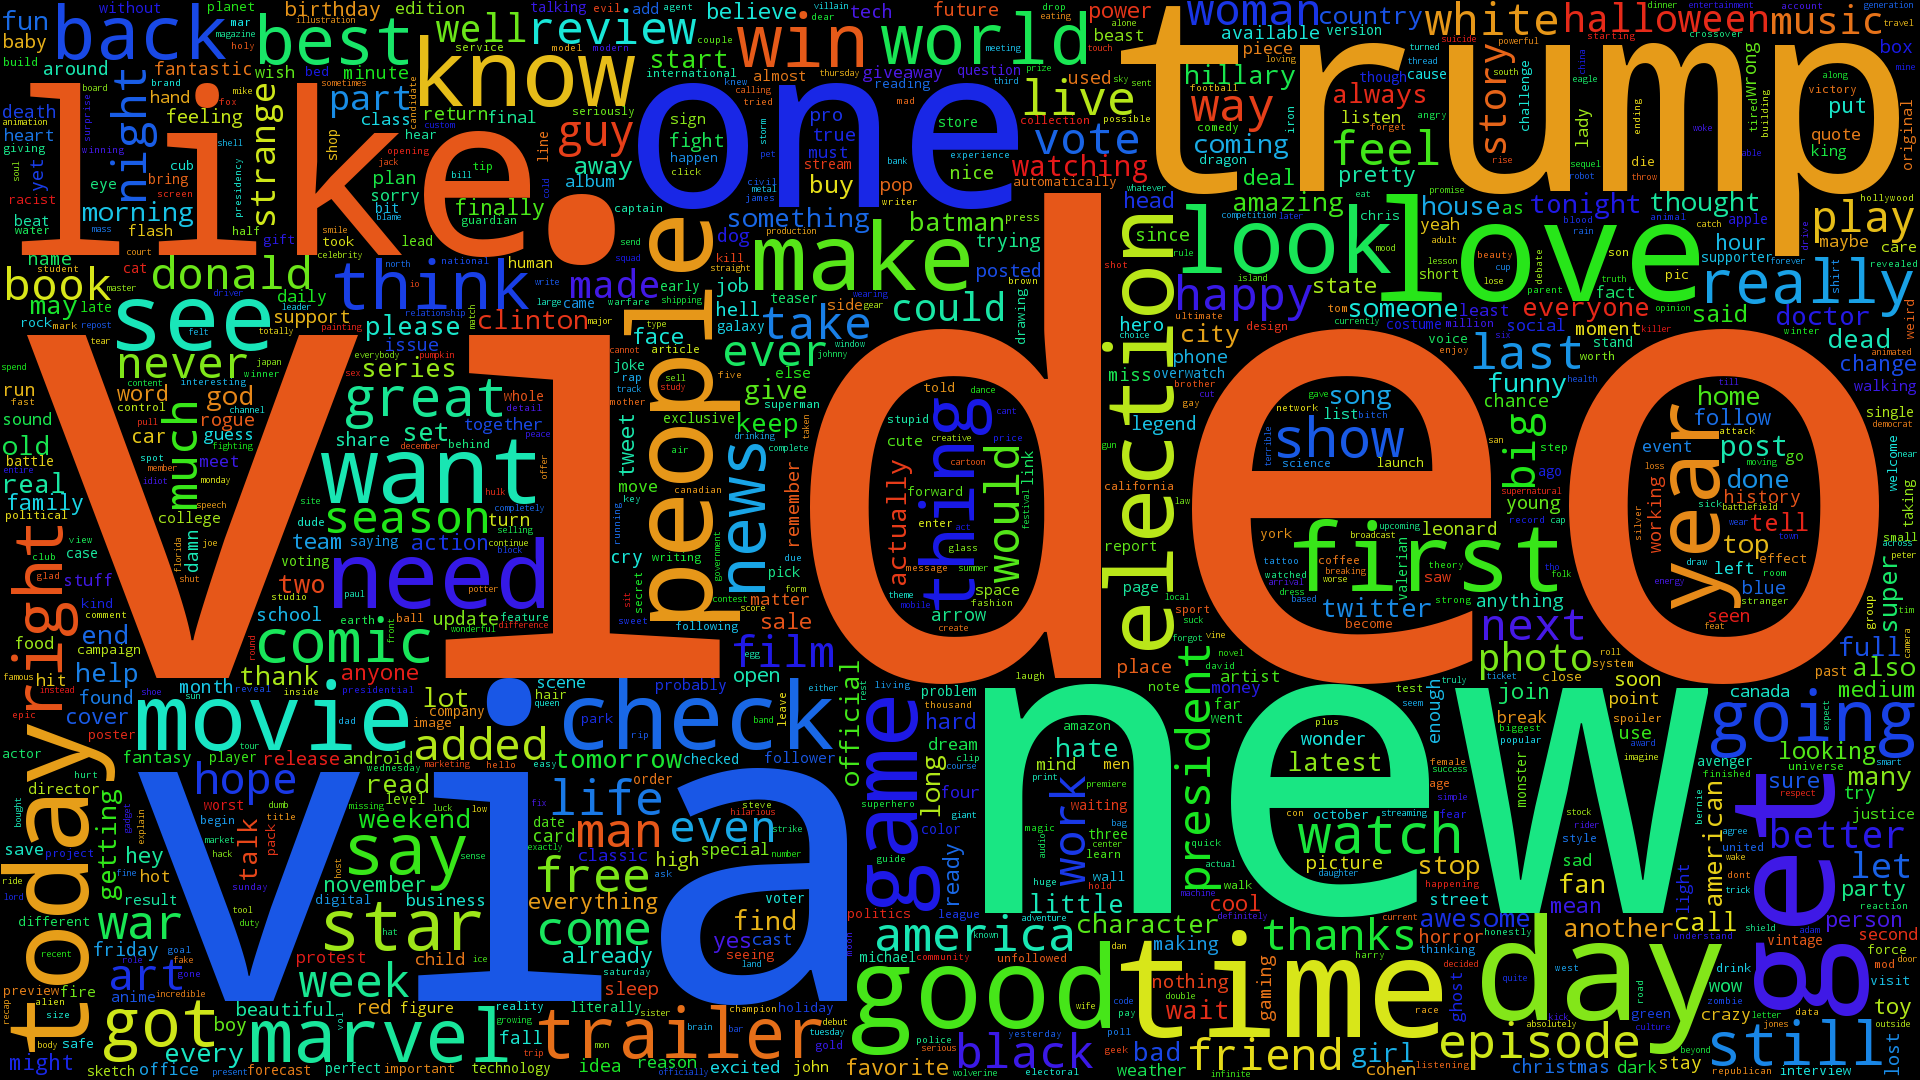

In [82]:
from IPython.display import Image
from IPython.core.display import HTML 
Image('cloud.png')